# 🧠 Mentor-Mentee Matching — Retrained with NLP
**What's new vs. the original notebook:**
- **NLP features** from mentor `bio` and mentee `goals` using TF-IDF + cosine similarity, plus sentence-transformer embeddings (optional GPU)
- **Weighted overlap scoring** for domain & skills (partial credit instead of binary Jaccard)
- **Experience gap penalty** — how far is the mentor's level above the mentee's?
- **Bio-goal semantic similarity** — does what the mentor says they do match what the mentee wants to achieve?
- **XGBoost with class-weight balancing** as the final model
- **SHAP explainability** so you know *why* each match was made
- Clean `recommend_for_new_mentee()` that works entirely from input data (no DB lookup needed)


## 0. Install & Import

In [1]:
# # Install extra packages (run once)
# import subprocess, sys
# pkgs = ["xgboost", "shap", "scikit-learn", "sentence-transformers"]
# for p in pkgs:
#     subprocess.run([sys.executable, "-m", "pip", "install", "-q", p], check=False)
# print(" packages ready")


In [ ]:
import os, warnings, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from dotenv import load_dotenv

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                              roc_auc_score, roc_curve, precision_recall_curve,
                              average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# XGBoost
import xgboost as xgb

# Optional: sentence transformers for deep semantic similarity
try:
    from sentence_transformers import SentenceTransformer
    SBERT_AVAILABLE = True
    print(" sentence-transformers available — semantic embeddings enabled")
except ImportError:
    SBERT_AVAILABLE = False
    print(" sentence-transformers not available — will use TF-IDF fallback")

# SHAP (optional)
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
print("imports complete")


## 1. Data Loading

In [ ]:
from sqlalchemy import create_engine, text

load_dotenv()
DB_URL = os.getenv("DATABASE_URL")
if not DB_URL:
    raise RuntimeError("Set DATABASE_URL in your .env file")

engine = create_engine(DB_URL, pool_pre_ping=True)

with engine.connect() as conn:
    mentors_df  = pd.read_sql_query(text("SELECT * FROM mentors  WHERE active = TRUE"), conn)
    mentees_df  = pd.read_sql_query(text("SELECT * FROM mentees  WHERE active = TRUE"), conn)
    interactions_df = pd.read_sql_query(text("""
        SELECT * FROM interactions
        WHERE status IN ('completed', 'cancelled')
          AND mentor_accepted IS NOT NULL
          AND mentee_accepted IS NOT NULL
    """), conn)

print(f"Mentors : {len(mentors_df)}")
print(f"Mentees : {len(mentees_df)}")
print(f"Interactions: {len(interactions_df)}  |  success rate: {interactions_df['successful_match'].mean():.2%}")


Mentors : 262
Mentees : 222
Interactions: 569  |  success rate: 41.12%


In [ ]:
# Normalise list-type columns stored as JSON strings
def parse_list_col(val):
    if isinstance(val, list):  return val
    if isinstance(val, str):
        try: return json.loads(val)
        except: return [v.strip() for v in val.split(',') if v.strip()]
    return []

for col in ['domains', 'skills']:
    mentors_df[col] = mentors_df[col].apply(parse_list_col)
for col in ['desired_domains', 'current_skills']:
    mentees_df[col] = mentees_df[col].apply(parse_list_col)

# Fill missing text fields
mentors_df['bio']   = mentors_df['bio'].fillna('').astype(str)
mentees_df['goals'] = mentees_df['goals'].fillna('').astype(str)

print(" list columns parsed")
print("Sample mentor domains:", mentors_df['domains'].iloc[0])
print("Sample mentee desired_domains:", mentees_df['desired_domains'].iloc[0])


 list columns parsed
Sample mentor domains: ['Leadership']
Sample mentee desired_domains: ['Sales', 'Marketing']


## 2. NLP Feature Engineering

### Strategy
| Signal | Method |
|--------|--------|
| Bio ↔ Goals text overlap | TF-IDF cosine similarity |
| Bio ↔ Goals semantic meaning | Sentence-BERT embeddings (if available) |
| Domain keyword coverage | Check if mentor bio mentions mentee desired domain keywords |
| Skill keyword coverage | Check if mentor bio/skills mention mentee skill keywords |

Bio and goals are the richest free-text signals we have — if a mentor's bio strongly overlaps with a mentee's stated goals, that's a much stronger match than simple list intersection.


In [ ]:
# ── TF-IDF cosine similarity between mentor bio and mentee goals ─────────────

# Build a combined corpus so the vocabulary covers both sides
all_texts = mentors_df['bio'].tolist() + mentees_df['goals'].tolist()

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),   # unigrams + bigrams
    max_features=5000,
    stop_words='english',
    min_df=2,             # ignore tokens seen in only 1 doc
)
tfidf.fit(all_texts)

mentor_bio_vecs  = tfidf.transform(mentors_df['bio'])
mentee_goal_vecs = tfidf.transform(mentees_df['goals'])

print(f" TF-IDF vocabulary size: {len(tfidf.vocabulary_)}")
print(f"  mentor bio matrix  : {mentor_bio_vecs.shape}")
print(f"  mentee goal matrix : {mentee_goal_vecs.shape}")

# Helper: look up pre-computed index
mentor_id_to_idx = {mid: i for i, mid in enumerate(mentors_df['mentor_id'])}
mentee_id_to_idx = {mid: i for i, mid in enumerate(mentees_df['mentee_id'])}


 TF-IDF vocabulary size: 614
  mentor bio matrix  : (262, 614)
  mentee goal matrix : (222, 614)


In [ ]:
# ── Optional: sentence-transformer embeddings ────────────────────────────────
# These capture semantic meaning, not just word overlap
# e.g. "machine learning" ~ "artificial intelligence" → high similarity

if SBERT_AVAILABLE:
    sbert = SentenceTransformer('all-MiniLM-L6-v2')  # small, fast, good quality
    
    mentor_sbert_vecs = sbert.encode(
        mentors_df['bio'].tolist(), 
        batch_size=64, show_progress_bar=True, convert_to_numpy=True
    )
    mentee_sbert_vecs = sbert.encode(
        mentees_df['goals'].tolist(),
        batch_size=64, show_progress_bar=True, convert_to_numpy=True
    )
    print(f" SBERT embeddings: {mentor_sbert_vecs.shape}")
else:
    mentor_sbert_vecs  = None
    mentee_sbert_vecs  = None
    print(" Using TF-IDF similarity only")


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

 SBERT embeddings: (262, 384)


In [ ]:
# ── NLP helper functions ─────────────────────────────────────────────────────

def bio_goal_tfidf_sim(mentor_idx: int, mentee_idx: int) -> float:
    """TF-IDF cosine similarity between mentor bio and mentee goals."""
    m_vec = mentor_bio_vecs[mentor_idx]
    e_vec = mentee_goal_vecs[mentee_idx]
    return float(cosine_similarity(m_vec, e_vec)[0, 0])


def bio_goal_sbert_sim(mentor_idx: int, mentee_idx: int) -> float:
    """Sentence-BERT cosine similarity (falls back to TF-IDF if unavailable)."""
    if mentor_sbert_vecs is None:
        return bio_goal_tfidf_sim(mentor_idx, mentee_idx)
    m_vec = mentor_sbert_vecs[mentor_idx].reshape(1, -1)
    e_vec = mentee_sbert_vecs[mentee_idx].reshape(1, -1)
    return float(cosine_similarity(m_vec, e_vec)[0, 0])


def bio_domain_coverage(mentor_bio: str, mentee_domains: list) -> float:
    """Fraction of mentee desired domains explicitly mentioned in mentor bio."""
    if not mentee_domains or not mentor_bio:
        return 0.0
    bio_lower = mentor_bio.lower()
    hits = sum(1 for d in mentee_domains if d.lower() in bio_lower)
    return hits / len(mentee_domains)


def bio_skill_coverage(mentor_bio: str, mentee_skills: list) -> float:
    """Fraction of mentee skills explicitly mentioned in mentor bio."""
    if not mentee_skills or not mentor_bio:
        return 0.0
    bio_lower = mentor_bio.lower()
    hits = sum(1 for s in mentee_skills if s.lower() in bio_lower)
    return hits / len(mentee_skills)


print(" NLP feature functions ready")


 NLP feature functions ready


## 3. Structured Feature Engineering (Improved)

### Changes from original
- **Weighted domain overlap**: partial credit when mentor covers *some* but not all desired domains
- **Experience gap score**: signed gap (mentor_exp - expected_exp_for_level); small positive gap is ideal
- **Skill depth ratio**: mentor skill count relative to mentee skill count (too many skills ≠ always better)


In [ ]:
def weighted_domain_overlap(mentor_domains, mentee_domains):
    """
    Weighted Jaccard on domains.
    A mentor covering 3 of 4 desired domains scores higher than one covering 1 of 4.
    """
    if not mentor_domains or not mentee_domains:
        return 0.0
    m_set, e_set = set(mentor_domains), set(mentee_domains)
    intersection = len(m_set & e_set)
    # Normalise by mentee's desired count (recall-style)
    return intersection / len(e_set)


def weighted_skill_overlap(mentor_skills, mentee_skills):
    """Jaccard similarity on skills (symmetric)."""
    if not mentor_skills or not mentee_skills:
        return 0.0
    m_set, e_set = set(mentor_skills), set(mentee_skills)
    union = len(m_set | e_set)
    return len(m_set & e_set) / union if union else 0.0


def experience_gap_score(mentor_exp: float, mentee_level: str) -> float:
    """
    How well does the mentor's experience match the mentee's level?
    Returns a value in [0, 1] — peaks when gap is just right (not too little, not too much).
    
    Ideal gaps by level:
      beginner     → mentor has 8-15 yrs  (big lead, lots to teach)
      intermediate → mentor has 5-12 yrs  (meaningful lead)
      advanced     → mentor has 3-8 yrs   (peer-ish, still ahead)
    """
    ideal = {'beginner': (8, 15), 'intermediate': (5, 12), 'advanced': (3, 8)}
    lo, hi = ideal.get(mentee_level, (5, 12))
    if lo <= mentor_exp <= hi:
        return 1.0
    elif mentor_exp < lo:
        return max(0.0, mentor_exp / lo)          # linearly penalise under-experienced
    else:
        return max(0.4, 1.0 - (mentor_exp - hi) / 20)  # soft penalty for very senior


def availability_compat(mentor_hours, mentee_hours):
    diff = abs(float(mentor_hours) - float(mentee_hours))
    return max(0.0, 1.0 - diff / 30.0)


def style_match(ms, es):   return 1 if ms == es else 0
def industry_match(mi, ei): return 1 if mi == ei else 0


LEVEL_NUM = {'beginner': 1, 'intermediate': 2, 'advanced': 3}

print(" structured feature functions ready")


 structured feature functions ready


In [ ]:
def build_feature_row(mentor, mentee, mentor_idx, mentee_idx):
    """
    Build ONE feature dict for a (mentor, mentee) pair.
    mentor / mentee : pandas Series (a row from the respective DataFrame)
    mentor_idx / mentee_idx : integer position in the pre-computed NLP matrices
    """
    m_domains = mentor.get('domains')   or []
    m_skills  = mentor.get('skills')    or []
    e_domains = mentee.get('desired_domains') or []
    e_skills  = mentee.get('current_skills')  or []

    return {
        # ── Structured overlap ──────────────────────────────────────────────
        'domain_overlap':       weighted_domain_overlap(m_domains, e_domains),
        'skill_overlap':        weighted_skill_overlap(m_skills,  e_skills),
        'availability_compat':  availability_compat(
                                    mentor.get('availability_hours', 10),
                                    mentee.get('availability_hours', 5)),
        'style_match':          style_match(
                                    mentor.get('mentorship_style'),
                                    mentee.get('preferred_style')),
        'industry_match':       industry_match(
                                    mentor.get('industry'),
                                    mentee.get('industry')),

        # ── Experience ──────────────────────────────────────────────────────
        'mentor_experience_years':  float(mentor.get('experience_years', 0)),
        'experience_gap_score':     experience_gap_score(
                                        float(mentor.get('experience_years', 0)),
                                        mentee.get('current_level', 'intermediate')),
        'mentee_level_numeric':     LEVEL_NUM.get(mentee.get('current_level'), 2),

        # ── Mentor quality signals ──────────────────────────────────────────
        'mentor_rating':         float(mentor.get('rating', 3.0)),
        'mentor_acceptance_rate':float(mentor.get('acceptance_rate', 0.5)),
        'mentor_total_mentees':  float(mentor.get('total_mentees', 0)),

        # ── Count features ──────────────────────────────────────────────────
        'mentor_domain_count':  len(m_domains),
        'mentee_domain_count':  len(e_domains),
        'mentor_skill_count':   len(m_skills),
        'mentee_skill_count':   len(e_skills),

        # ── NLP features ────────────────────────────────────────────────────
        'bio_goal_tfidf_sim':   bio_goal_tfidf_sim(mentor_idx, mentee_idx),
        'bio_goal_sbert_sim':   bio_goal_sbert_sim(mentor_idx, mentee_idx),
        'bio_domain_coverage':  bio_domain_coverage(
                                    mentor.get('bio', ''), e_domains),
        'bio_skill_coverage':   bio_skill_coverage(
                                    mentor.get('bio', ''), e_skills),
    }


FEATURE_COLS = [
    'domain_overlap', 'skill_overlap', 'availability_compat',
    'style_match', 'industry_match',
    'mentor_experience_years', 'experience_gap_score', 'mentee_level_numeric',
    'mentor_rating', 'mentor_acceptance_rate', 'mentor_total_mentees',
    'mentor_domain_count', 'mentee_domain_count',
    'mentor_skill_count', 'mentee_skill_count',
    'bio_goal_tfidf_sim', 'bio_goal_sbert_sim',
    'bio_domain_coverage', 'bio_skill_coverage',
]

print(f" {len(FEATURE_COLS)} features defined")
print(FEATURE_COLS)


 19 features defined
['domain_overlap', 'skill_overlap', 'availability_compat', 'style_match', 'industry_match', 'mentor_experience_years', 'experience_gap_score', 'mentee_level_numeric', 'mentor_rating', 'mentor_acceptance_rate', 'mentor_total_mentees', 'mentor_domain_count', 'mentee_domain_count', 'mentor_skill_count', 'mentee_skill_count', 'bio_goal_tfidf_sim', 'bio_goal_sbert_sim', 'bio_domain_coverage', 'bio_skill_coverage']


## 4. Build Training Dataset

In [ ]:
print("Building feature matrix from interactions...")
rows, skipped = [], 0

for _, ix in interactions_df.iterrows():
    mid, eid = ix['mentor_id'], ix['mentee_id']

    m_rows = mentors_df[mentors_df['mentor_id'] == mid]
    e_rows = mentees_df[mentees_df['mentee_id'] == eid]
    if m_rows.empty or e_rows.empty:
        skipped += 1
        continue

    mentor = m_rows.iloc[0]
    mentee = e_rows.iloc[0]
    m_idx  = mentor_id_to_idx[mid]
    e_idx  = mentee_id_to_idx[eid]

    feat = build_feature_row(mentor, mentee, m_idx, e_idx)
    feat['mentor_id']      = mid
    feat['mentee_id']      = eid
    feat['interaction_id'] = ix['interaction_id']
    feat['successful_match'] = ix['successful_match']
    rows.append(feat)

train_df = pd.DataFrame(rows)
print(f" {len(train_df)} rows built  |  {skipped} skipped")
print(f"Success rate: {train_df['successful_match'].mean():.2%}")
train_df[FEATURE_COLS].describe()


Building feature matrix from interactions...
 449 rows built  |  120 skipped
Success rate: 40.09%


,domain_overlap,skill_overlap,availability_compat,style_match,industry_match,mentor_experience_years,experience_gap_score,mentee_level_numeric,mentor_rating,mentor_acceptance_rate,mentor_total_mentees,mentor_domain_count,mentee_domain_count,mentor_skill_count,mentee_skill_count,bio_goal_tfidf_sim,bio_goal_sbert_sim,bio_domain_coverage,bio_skill_coverage
count,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000
mean,0.092428,0.008827,0.670379,0.209354,0.071269,12.752784,0.851058,1.951002,4.321292,0.809065,5.320713,1.908686,1.403118,5.755011,1.374165,0.018256,0.332211,0.075724,0.018745
std,0.249617,0.036225,0.238029,0.407301,0.257561,4.355712,0.173624,0.872346,0.517523,0.166103,3.160095,0.696381,0.491071,2.377842,1.066055,0.047691,0.103621,0.231095,0.109978
min,0.000000,0.000000,0.166667,0.000000,0.000000,5.000000,0.400000,1.000000,3.220000,0.310000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.057597,0.000000,0.000000
25%,0.000000,0.000000,0.500000,0.000000,0.000000,9.000000,0.750000,1.000000,3.940000,0.690000,3.000000,1.000000,1.000000,4.000000,1.000000,0.000000,0.264148,0.000000,0.000000
50%,0.000000,0.000000,0.666667,0.000000,0.000000,12.000000,0.900000,2.000000,4.340000,0.820000,5.000000,2.000000,1.000000,6.000000,1.000000,0.000000,0.326970,0.000000,0.000000
75%,0.000000,0.000000,0.833333,0.000000,0.000000,17.000000,1.000000,3.000000,4.770000,0.980000,8.000000,2.000000,2.000000,7.000000,2.000000,0.019000,0.399830,0.000000,0.000000
max,1.000000,0.222222,1.000000,1.000000,1.000000,20.000000,1.000000,3.000000,5.000000,1.000000,10.000000,3.000000,2.000000,12.000000,4.000000,0.382502,0.704842,1.000000,1.000000


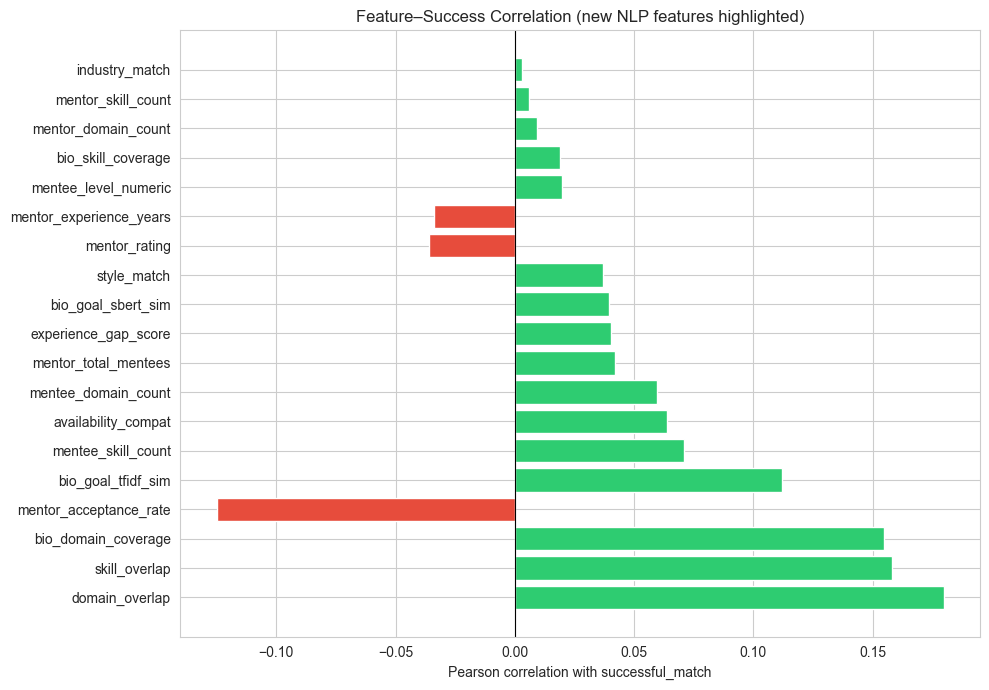

Top 5 positive features:
domain_overlap            0.179766
skill_overlap             0.158049
bio_domain_coverage       0.154932
mentor_acceptance_rate   -0.124944
bio_goal_tfidf_sim        0.112086
dtype: float64

Top 5 negative features:
mentee_level_numeric    0.019921
bio_skill_coverage      0.018995
mentor_domain_count     0.009385
mentor_skill_count      0.005927
industry_match          0.003029
dtype: float64


In [ ]:
# Correlation heatmap — see which new NLP features correlate with success
corr_vals = {c: train_df[c].corr(train_df['successful_match'].astype(float))
             for c in FEATURE_COLS}
corr_df = pd.Series(corr_vals).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 7))
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in corr_df]
plt.barh(corr_df.index, corr_df.values, color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Pearson correlation with successful_match')
plt.title('Feature–Success Correlation (new NLP features highlighted)')
plt.tight_layout()
plt.show()

print("Top 5 positive features:")
print(corr_df.head())
print("\nTop 5 negative features:")
print(corr_df.tail())


## 5. Train / Test Split

In [ ]:
X = train_df[FEATURE_COLS]
y = train_df['successful_match'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale for models that need it (LR)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

print(f"Train: {len(X_train)}  |  Test: {len(X_test)}")
print(f"Class balance  train: {y_train.mean():.2%}  test: {y_test.mean():.2%}")


Train: 359  |  Test: 90
Class balance  train: 40.11%  test: 40.00%


## 6. Model Training & Comparison

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval_model(name, y_true, y_pred, y_prob):
    
    print(f"  {name}")
    
    print(classification_report(y_true, y_pred, target_names=['Fail','Success']))
    print(f"ROC-AUC : {roc_auc_score(y_true, y_prob):.4f}")
    print(f"Avg-Prec: {average_precision_score(y_true, y_prob):.4f}")
    return {
        'model': name,
        'accuracy':  accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall':    recall_score(y_true, y_pred, zero_division=0),
        'f1':        f1_score(y_true, y_pred, zero_division=0),
        'roc_auc':   roc_auc_score(y_true, y_prob),
        'avg_prec':  average_precision_score(y_true, y_prob),
    }

results = []


In [ ]:
# ── Logistic Regression (baseline) ──────────────────────────────────────────
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_sc, y_train)
results.append(eval_model('Logistic Regression',
    y_test, lr.predict(X_test_sc), lr.predict_proba(X_test_sc)[:,1]))


  Logistic Regression
              precision    recall  f1-score   support

        Fail       0.63      0.63      0.63        54
     Success       0.44      0.44      0.44        36

    accuracy                           0.56        90
   macro avg       0.54      0.54      0.54        90
weighted avg       0.56      0.56      0.56        90

ROC-AUC : 0.5159
Avg-Prec: 0.4687


In [ ]:
# ── Random Forest ────────────────────────────────────────────────────────────
rf = RandomForestClassifier(
    n_estimators=200, max_depth=12, min_samples_leaf=5,
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)
results.append(eval_model('Random Forest',
    y_test, rf.predict(X_test), rf.predict_proba(X_test)[:,1]))


  Random Forest
              precision    recall  f1-score   support

        Fail       0.53      0.57      0.55        54
     Success       0.28      0.25      0.26        36

    accuracy                           0.44        90
   macro avg       0.41      0.41      0.41        90
weighted avg       0.43      0.44      0.44        90

ROC-AUC : 0.4660
Avg-Prec: 0.4473


In [ ]:
# ── XGBoost (primary model) ──────────────────────────────────────────────────
# scale_pos_weight handles class imbalance automatically
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
spw = neg / pos if pos > 0 else 1.0

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=spw,
    use_label_encoder=False,
    eval_metric='auc',
    early_stopping_rounds=20,
    random_state=42,
    n_jobs=-1,
)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
results.append(eval_model('XGBoost',
    y_test, xgb_model.predict(X_test), xgb_model.predict_proba(X_test)[:,1]))


  XGBoost
              precision    recall  f1-score   support

        Fail       0.55      0.48      0.51        54
     Success       0.35      0.42      0.38        36

    accuracy                           0.46        90
   macro avg       0.45      0.45      0.45        90
weighted avg       0.47      0.46      0.46        90

ROC-AUC : 0.4902
Avg-Prec: 0.4531



MODEL COMPARISON
                     accuracy  precision  recall      f1  roc_auc  avg_prec
model                                                                      
Logistic Regression    0.5556     0.4444  0.4444  0.4444   0.5159    0.4687
Random Forest          0.4444     0.2812  0.2500  0.2647   0.4660    0.4473
XGBoost                0.4556     0.3488  0.4167  0.3797   0.4902    0.4531


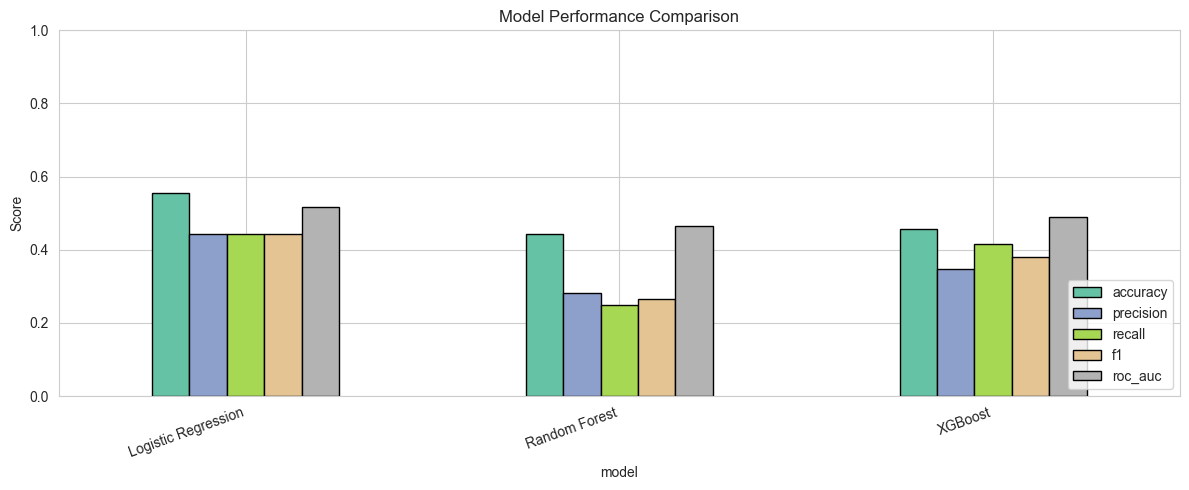

In [ ]:
# ── Comparison table ─────────────────────────────────────────────────────────
results_df = pd.DataFrame(results).set_index('model')
print("\nMODEL COMPARISON")
print(results_df.round(4).to_string())

ax = results_df[['accuracy','precision','recall','f1','roc_auc']].plot(
    kind='bar', figsize=(12, 5), colormap='Set2', edgecolor='black')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=20, ha='right')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## 7. Feature Importance & SHAP Explainability

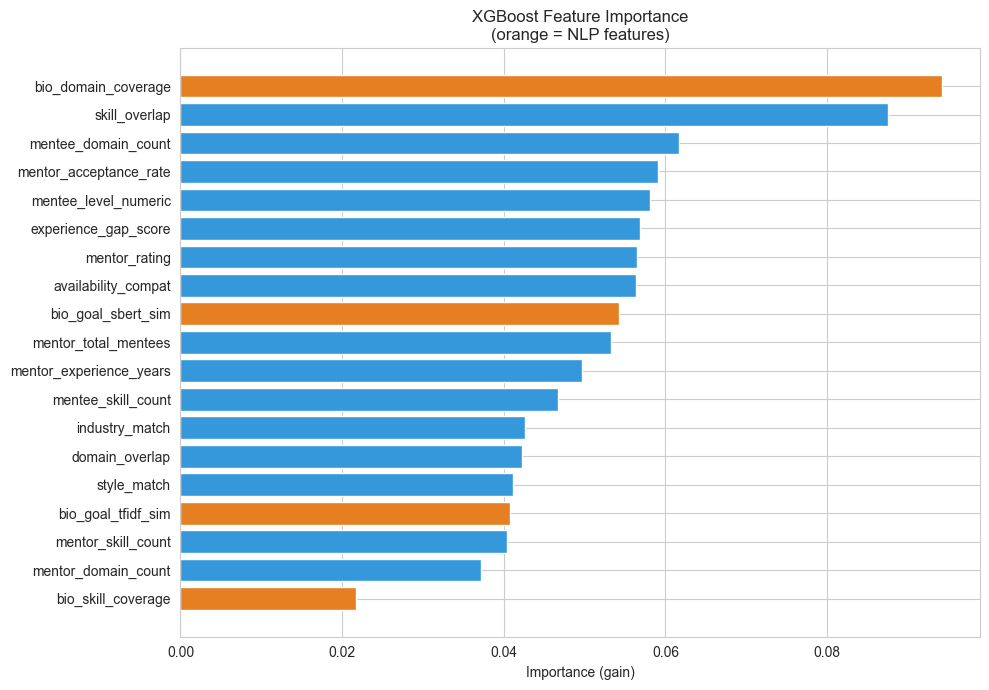

In [ ]:
# XGBoost native importance
xgb_imp = pd.Series(xgb_model.feature_importances_, index=FEATURE_COLS).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
colors = ['#e67e22' if 'bio' in f or 'sbert' in f or 'tfidf' in f else '#3498db' for f in xgb_imp.index]
plt.barh(xgb_imp.index[::-1], xgb_imp.values[::-1], color=colors[::-1])
plt.xlabel('Importance (gain)')
plt.title('XGBoost Feature Importance\n(orange = NLP features)')
plt.tight_layout()
plt.show()


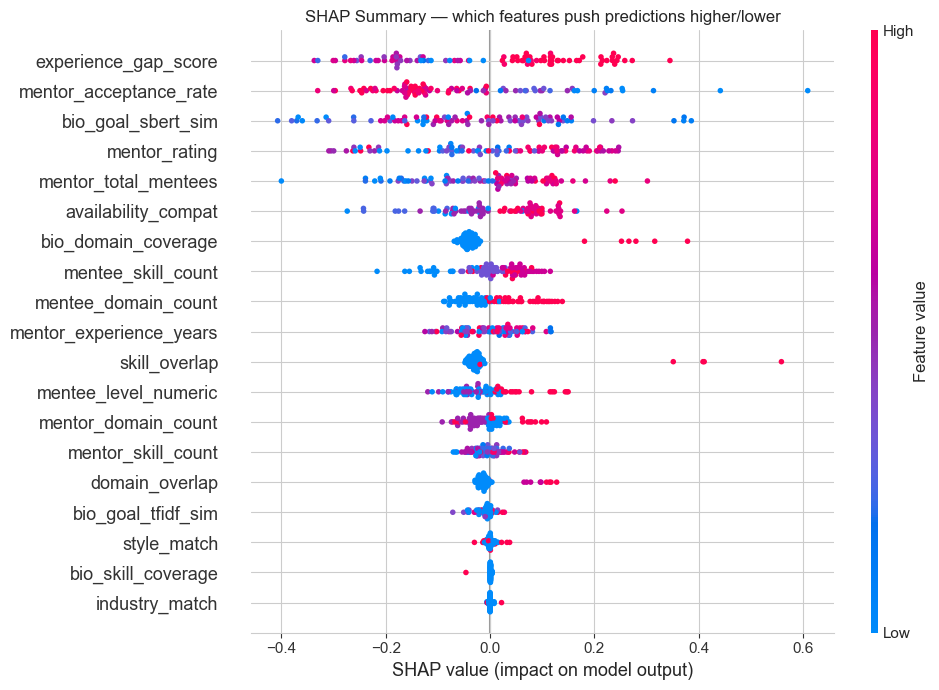

In [ ]:
if SHAP_AVAILABLE:
    explainer = shap.TreeExplainer(xgb_model)
    shap_vals  = explainer.shap_values(X_test)

    plt.figure(figsize=(10, 7))
    shap.summary_plot(shap_vals, X_test, feature_names=FEATURE_COLS,
                      show=False, plot_size=(10, 7))
    plt.title("SHAP Summary — which features push predictions higher/lower")
    plt.tight_layout()
    plt.show()
else:
    print("Install shap for SHAP plots: pip install shap")


## 8. Recommend Mentors from Input Data

This is the core function used by the Flask API — it works **entirely from input dictionaries**, no DB lookup needed for the mentee.


In [ ]:
def build_feature_row_from_dict(mentor_series, mentee_dict,
                                 mentor_bio_vecs, tfidf, sbert_model=None):
    """
    Build features for a (mentor_series, mentee_dict) pair
    where mentee_dict comes directly from a form / API request.
    
    mentor_series : pandas Series (one row of mentors_df)
    mentee_dict   : dict with keys matching mentees_df columns
    """
    m_domains = mentor_series.get('domains')  or []
    m_skills  = mentor_series.get('skills')   or []
    e_domains = mentee_dict.get('desired_domains') or []
    e_skills  = mentee_dict.get('current_skills')  or []
    mentor_bio = str(mentor_series.get('bio', ''))
    mentee_goals = str(mentee_dict.get('goals', ''))

    # TF-IDF similarity on the fly
    m_vec = mentor_bio_vecs[mentor_series.name]   # precomputed
    e_vec = tfidf.transform([mentee_goals])
    tfidf_sim = float(cosine_similarity(m_vec, e_vec)[0, 0])

    # SBERT similarity on the fly (if available)
    if sbert_model is not None and mentor_sbert_vecs is not None:
        e_emb = sbert_model.encode([mentee_goals], convert_to_numpy=True)
        sbert_sim = float(cosine_similarity(
            mentor_sbert_vecs[mentor_series.name].reshape(1,-1), e_emb)[0,0])
    else:
        sbert_sim = tfidf_sim  # fallback

    return {
        'domain_overlap':        weighted_domain_overlap(m_domains, e_domains),
        'skill_overlap':         weighted_skill_overlap(m_skills, e_skills),
        'availability_compat':   availability_compat(
                                     float(mentor_series.get('availability_hours', 10)),
                                     float(mentee_dict.get('availability_hours', 5))),
        'style_match':           style_match(
                                     mentor_series.get('mentorship_style'),
                                     mentee_dict.get('preferred_style')),
        'industry_match':        industry_match(
                                     mentor_series.get('industry'),
                                     mentee_dict.get('industry')),
        'mentor_experience_years': float(mentor_series.get('experience_years', 0)),
        'experience_gap_score':    experience_gap_score(
                                       float(mentor_series.get('experience_years', 0)),
                                       mentee_dict.get('current_level', 'intermediate')),
        'mentee_level_numeric':    LEVEL_NUM.get(mentee_dict.get('current_level'), 2),
        'mentor_rating':           float(mentor_series.get('rating', 3.0)),
        'mentor_acceptance_rate':  float(mentor_series.get('acceptance_rate', 0.5)),
        'mentor_total_mentees':    float(mentor_series.get('total_mentees', 0)),
        'mentor_domain_count':     len(m_domains),
        'mentee_domain_count':     len(e_domains),
        'mentor_skill_count':      len(m_skills),
        'mentee_skill_count':      len(e_skills),
        'bio_goal_tfidf_sim':      tfidf_sim,
        'bio_goal_sbert_sim':      sbert_sim,
        'bio_domain_coverage':     bio_domain_coverage(mentor_bio, e_domains),
        'bio_skill_coverage':      bio_skill_coverage(mentor_bio, e_skills),
    }


def recommend_for_new_mentee(mentee_dict, top_k=5, model=None,
                              explain=False):
    """
    Recommend top-K mentors for a new mentee described by a plain dict.
    
    Parameters
    ----------
    mentee_dict : dict
        Must contain (at minimum):
          desired_domains (list), current_skills (list), current_level (str),
          industry (str), preferred_style (str), availability_hours (int),
          goals (str)  ← free-text, used by NLP
    top_k : int
        Number of results to return
    model : trained classifier
        Defaults to xgb_model
    explain : bool
        If True and SHAP is available, show a force-plot for the top match
    
    Returns
    -------
    pandas DataFrame with columns: mentor_name, match_score, domains,
        experience_years, rating, bio + all match_details
    """
    if model is None:
        model = xgb_model

    _sbert = sbert if SBERT_AVAILABLE else None

    # Build feature row for every active mentor
    feat_rows = []
    for pos, mentor in mentors_df.iterrows():
        feat = build_feature_row_from_dict(mentor, mentee_dict,
                                            mentor_bio_vecs, tfidf, _sbert)
        feat_rows.append(feat)

    feat_df = pd.DataFrame(feat_rows)[FEATURE_COLS]
    probs   = model.predict_proba(feat_df)[:, 1]

    # Rank and pick top-K
    top_idx = np.argsort(probs)[::-1][:top_k]
    recs = []
    for i in top_idx:
        mentor = mentors_df.iloc[i]
        f = feat_rows[i]
        recs.append({
            'mentor_id':           int(mentor.get('mentor_id', i)),
            'mentor_name':         str(mentor.get('name', '?')),
            'match_score':         round(float(probs[i]), 4),
            'industry':            str(mentor.get('industry', '')),
            'experience_years':    int(mentor.get('experience_years', 0)),
            'rating':              round(float(mentor.get('rating', 0)), 2),
            'availability_hours':  int(mentor.get('availability_hours', 0)),
            'mentorship_style':    str(mentor.get('mentorship_style', '')),
            'domains':             mentor.get('domains') or [],
            'skills':              mentor.get('skills') or [],
            'bio':                 str(mentor.get('bio', ''))[:200],
            # key match signals
            'domain_overlap':      round(f['domain_overlap'], 3),
            'skill_overlap':       round(f['skill_overlap'], 3),
            'bio_tfidf_sim':       round(f['bio_goal_tfidf_sim'], 3),
            'bio_sbert_sim':       round(f['bio_goal_sbert_sim'], 3),
            'bio_domain_coverage': round(f['bio_domain_coverage'], 3),
            'experience_gap_ok':   round(f['experience_gap_score'], 3),
            'style_match':         bool(f['style_match']),
            'industry_match':      bool(f['industry_match']),
        })

    if explain and SHAP_AVAILABLE and recs:
        print(f"\n SHAP explanation for top match: {recs[0]['mentor_name']}")
        exp = shap.TreeExplainer(model)
        sv  = exp.shap_values(feat_df.iloc[top_idx[0]:top_idx[0]+1])
        shap.force_plot(exp.expected_value, sv[0], feat_df.iloc[top_idx[0]],
                        feature_names=FEATURE_COLS, matplotlib=True)
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(recs)


print(" recommend_for_new_mentee() ready")


 recommend_for_new_mentee() ready



 SHAP explanation for top match: Joe Yates


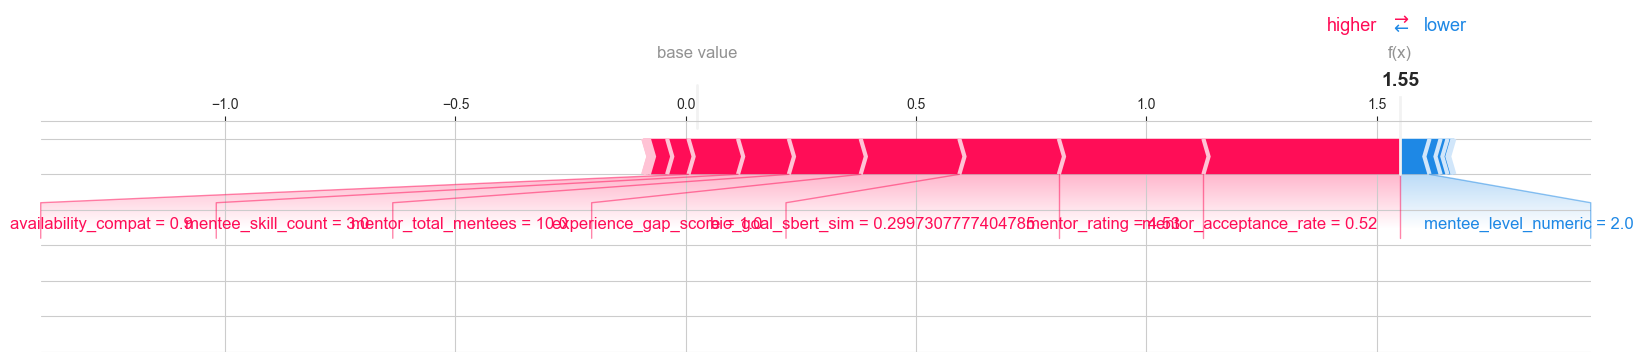

<Figure size 640x480 with 0 Axes>


Top 5 mentor recommendations for Aisha Bello
     mentor_name  match_score  domain_overlap  skill_overlap  bio_sbert_sim  experience_years  rating
       Joe Yates       0.8251             0.0          0.000          0.300                12    4.53
     Gary Meyers       0.8119             0.0          0.000          0.299                12    4.58
Catherine Wilson       0.8007             0.5          0.000          0.315                12    4.32
    Nancy Miller       0.7448             0.0          0.111          0.300                 9    4.06
 Danielle Maddox       0.7361             0.0          0.125          0.298                11    3.65


In [ ]:
# ── Quick demo with a synthetic new mentee ───────────────────────────────────
sample_mentee = {
    "name":            "Aisha Bello",
    "desired_domains": ["Artificial Intelligence", "Product Management"],
    "current_skills":  ["Python", "Data Analysis", "SQL"],
    "current_level":   "intermediate",
    "industry":        "Tech",
    "preferred_style": "structured",
    "availability_hours": 8,
    "goals": (
        "I want to transition from data analyst to AI product manager. "
        "I need guidance on building ML-powered products, understanding "
        "model deployment, and developing a product intuition for AI."
    )
}

recs = recommend_for_new_mentee(sample_mentee, top_k=5, explain=SHAP_AVAILABLE)
print(f"\nTop 5 mentor recommendations for {sample_mentee['name']}")
print(recs[['mentor_name','match_score','domain_overlap','skill_overlap',
            'bio_sbert_sim','experience_years','rating']].to_string(index=False))


## 9. Cross-Validation Robustness Check

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, m, Xd in [
    ('Logistic Regression', lr,        pd.DataFrame(X_train_sc, columns=FEATURE_COLS)),
    ('Random Forest',       rf,        X_train),
    ('XGBoost',             xgb_model, X_train),
]:
    scores = cross_val_score(m, Xd, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"{name:<25}  AUC: {scores.mean():.4f} ± {scores.std():.4f}")


## 10. Save Artifacts

In [ ]:
import os
save_dir = os.path.join(os.path.expanduser('~'), 'Documents',
                        'recommendation system', 'model')
os.makedirs(save_dir, exist_ok=True)

joblib.dump(xgb_model,   os.path.join(save_dir, 'mentor_matching_modelv2.pkl'))
joblib.dump(scaler,      os.path.join(save_dir, 'feature_scalerv2.pkl'))
joblib.dump(FEATURE_COLS,os.path.join(save_dir, 'feature_columnsv2.pkl'))
joblib.dump(tfidf,       os.path.join(save_dir, 'tfidf_vectorizerv2.pkl'))

if SBERT_AVAILABLE:
    joblib.dump(mentor_sbert_vecs, os.path.join(save_dir, 'mentor_sbert_vecsv2.pkl'))

print(" Saved to", save_dir)
print("  mentor_matching_modelv2.pkl")
print("  feature_scalerv2.pkl")
print("  feature_columnsv2.pkl")
print("  tfidf_vectorizerv2.pkl")
if SBERT_AVAILABLE:
    print("  mentor_sbert_vecsv2.pkl")